# Debugging and performances

In [1]:
# Hidden cell
import os, sys
import numpy as np
import pandas as pd
import xarray as xr
print("xarray: %s, %s" % (xr.__version__, xr.__file__))

import matplotlib.pyplot as plt
%matplotlib inline
sys.path.insert(0, os.path.abspath('/Users/gmaze/git/github/gmaze/pyxpcm'))

import pyxpcm
print("pyxpcm: %s, %s" % (pyxpcm.__version__, pyxpcm.__file__))

xarray: 0.14.2.dev62+g6d1434e9, /Users/gmaze/anaconda/envs/obidam36/lib/python3.6/site-packages/xarray/__init__.py


pyxpcm: 0.4.0, /Users/gmaze/git/github/gmaze/pyxpcm/pyxpcm/__init__.py


**Import and set-up**

Import the library and toy data

In [2]:
import pyxpcm
from pyxpcm.models import pcm

# Load a dataset to work with:
ds = pyxpcm.tutorial.open_dataset('argo').load()

# Define vertical axis and features to use:
z = np.arange(0.,-1000.,-10.)
features_pcm = {'temperature': z, 'salinity': z}
features_in_ds = {'temperature': 'TEMP', 'salinity': 'PSAL'}

## Debugging

Use option ``debug`` to print log messages 

In [3]:
# Instantiate a new PCM:
m = pcm(K=8, features=features_pcm, debug=True)

# Fit with log:
m.fit(ds, features=features_in_ds);

> Start preprocessing for action 'fit'



	> Preprocessing xarray dataset 'TEMP' as PCM feature 'temperature'
	 X RAVELED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))]
		Output axis is in the input axis, not need to interpolate, simple intersection
	 X INTERPOLATED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))]
	 X SCALED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	 X REDUCED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	temperature pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of temperature

	> Preprocessing xarray dataset 'PSAL' as PCM feature 'salinity'


	 X RAVELED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (282,))]
		Output axis is in the input axis, not need to interpolate, simple intersection
	 X INTERPOLATED with success [<class 'xarray.core.dataarray.DataArray'>, <class 'dask.array.core.Array'>, ((7560,), (100,))]
	 X SCALED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	 X REDUCED with success) [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	salinity pre-processed with success,  [<class 'xarray.core.dataarray.DataArray'>, <class 'numpy.ndarray'>, None]
	Homogenisation for fit of salinity
	Features array shape and type for xarray: (7560, 30) <class 'numpy.ndarray'> <class 'memoryview'>
> Preprocessing done, working with final X (<class 'xarray.core.dataarray.DataArray'>) array of shape: (7560, 30)  and sampling dimensions: ['N_PROF']


## Performance / Optimisation

Use ``timeit`` and ``timeit_verb`` to compute computation time of PCM operations

Times are accessible as a pandas Dataframe in ``timeit`` pyXpcm instance property.

The pyXpcm ``m.plot.timeit()`` plot method allows for a simple visualisation of times.

### Time readings during execution

In [4]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=1)
m.fit(ds, features=features_in_ds);

  fit.1-preprocess.1-mask: 20 ms
  fit.1-preprocess.2-feature_temperature.1-ravel: 29 ms
  fit.1-preprocess.2-feature_temperature.2-interp: 0 ms
  fit.1-preprocess.2-feature_temperature.3-scale_fit: 7 ms
  fit.1-preprocess.2-feature_temperature.4-scale_transform: 4 ms
  fit.1-preprocess.2-feature_temperature.5-reduce_fit: 10 ms
  fit.1-preprocess.2-feature_temperature.6-reduce_transform: 2 ms
  fit.1-preprocess.2-feature_temperature.total: 55 ms
  fit.1-preprocess: 55 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.2-feature_salinity.1-ravel: 25 ms
  fit.1-preprocess.2-feature_salinity.2-interp: 0 ms
  fit.1-preprocess.2-feature_salinity.3-scale_fit: 7 ms
  fit.1-preprocess.2-feature_salinity.4-scale_transform: 4 ms
  fit.1-preprocess.2-feature_salinity.5-reduce_fit: 9 ms
  fit.1-preprocess.2-feature_salinity.6-reduce_transform: 2 ms
  fit.1-preprocess.2-feature_salinity.total: 50 ms
  fit.1-preprocess: 50 ms
  fit.1-preprocess.3-homogeniser: 1 ms
  fit.1-preprocess.4-xarr

  fit.fit: 1743 ms
  fit.score: 9 ms
  fit: 1884 ms


### A posteriori Execution time analysis

In [5]:
# Create a PCM and execute methods:
m = pcm(K=8, features=features_pcm, timeit=True, timeit_verb=0)
m.fit(ds, features=features_in_ds);
m.predict(ds, features=features_in_ds);
m.fit_predict(ds, features=features_in_ds);

In [6]:
m.timeit

Method       Sub-method    Sub-sub-method         Sub-sub-sub-method
fit          1-preprocess  1-mask                 total                   18.404007
                           2-feature_temperature  1-ravel                 28.075933
                                                  2-interp                 0.684977
                                                  3-scale_fit             10.245085
                                                  4-scale_transform        4.314899
                                                  5-reduce_fit            13.271093
                                                  6-reduce_transform       2.992868
                                                  total                   59.717894
                           total                                         240.025282
                           3-homogeniser          total                    2.261877
                           2-feature_salinity     1-ravel                 22.089243
       

## Visualisation help

### Main steps by method

Sub-method,1-preprocess,fit,predict,score,xarray
Method,,,,,
fit,478.437424,1767.950773,NaN,8.771181,NaN
fit_predict,303.014040,1761.704922,7.534742,8.709669,5.710125
predict,329.038143,NaN,9.085178,8.865118,6.392956


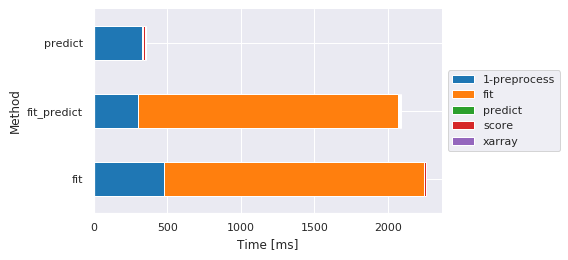

In [7]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-method', style='darkgrid') # Default group/split
df

### Preprocessing main steps by method

Sub-sub-method,1-mask,2-feature_salinity,2-feature_temperature,3-homogeniser,4-xarray
Method,,,,,
fit,18.404007,97.491503,119.302750,2.261877,0.952005
fit_predict,21.242142,65.464973,60.814142,2.266169,0.962973
predict,19.385815,66.843987,75.625420,1.111031,0.947952


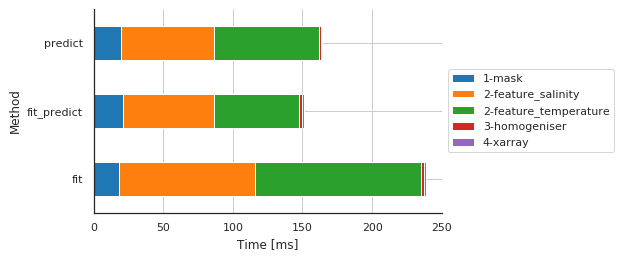

In [8]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-method')
df

### Preprocessing details by method

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Method,,,,,,
fit,50.165176,1.368046,19.125223,9.258747,22.642136,5.699873
fit_predict,44.401884,1.734972,0.003099,10.915995,0.004053,5.958080
predict,55.557013,1.468182,0.002146,9.112358,0.002623,4.988909


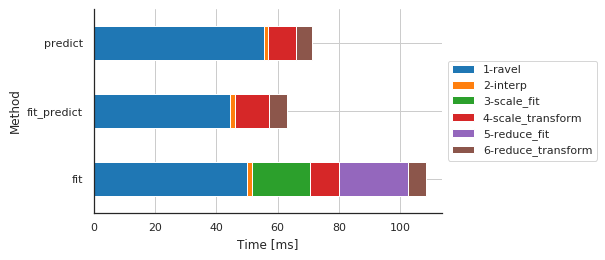

In [9]:
fig, ax, df = m.plot.timeit(group='Method', split='Sub-sub-sub-method')
df

### Preprocessing details by features

Sub-sub-sub-method,1-ravel,2-interp,3-scale_fit,4-scale_transform,5-reduce_fit,6-reduce_transform
Sub-sub-method,,,,,,
2-feature_salinity,0.072009,0.002419,0.008882,0.014636,0.009374,0.007387
2-feature_temperature,0.078115,0.002152,0.010248,0.014651,0.013275,0.009260


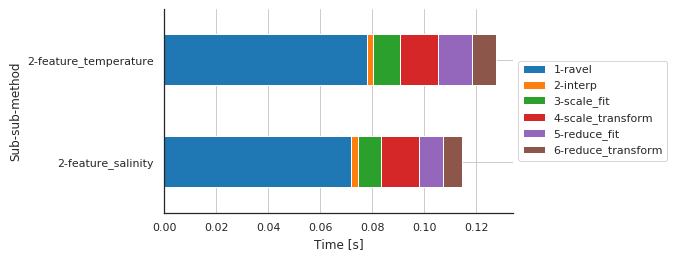

In [10]:
fig, ax, df = m.plot.timeit(split='Sub-sub-sub-method', group='Sub-sub-method', unit='s')
df